# Multi-Armed Bandits for Sequential Decision Making

# Fundamental tradeoff between
- Information and Rewards
- Learning and Optimization
- Exploration and Exploitation

<img src="images/amzn2.png" width="300" height="300"/> 
<img src="images/tube.jpeg" width="300" height="300"/>
<img src="images/breakout.gif" width="300" height="300"/>
<img src="images/robot.jpeg" width="300" height="300"/>
<img src="images/chess.webp" width="300" height="300"/>

# Problem Formulation
We have a limited budget to use on multiple rigged slot machines in a casino. Which one to put money on? 

<img src="images/bandit2.jpeg" width="500"/>

When should we stop trying (exploration) and start playing (exploitation)?

Formal Definition:

- Online decisions
    - At every time step t = 1, 2, ..., *T*, pull one arm out of *N* arms
- Stochastic feedback
    - For each arm i, reward is generated **i.i.d** from a **fixed but unknown distribution** with mean µ<sub>i</sub>
- Bandit feedback
    - Only the reward of the pulled arm can be observed
- Minimize **regret** over T periods
    $$E[\sum_{t=1}^T(µ^* - µ_{i_t})] \text{, where } µ^* = \max_{j} µ_j$$ 


# Distinction from Reinforcement Learning
Action taken by the agent does not influence the next state of the environment
- Agents are not modeling state transitions
- Agents do not credit rewards to past actions
- Agents do not try to 'plan ahead' to get to reward-rich states

# Outline

- Basic environment setup
- How to evaluate actions
- Basic algorithm techniques for the stochastic MAB problem
    - Greedy
    - Epsilon Greedy
    - UCB
    - Thompson Sampling
- Useful Generalizations 
    - Contextual bandits
    - Bandits with constraints
    - Reinforcement learning


In [321]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

In [315]:
class ArmedBanditsEnv():
    """
    Our main environment class. 
    Vectorized to allow multiple experiments to be run concurrently.
    Receives numpy arrays for the means and standard deviations for each action.
    Has a step method which allows taking draws from a normal (Gaussian) distribution and returns a vector of reward obtained for each experiment.
    """
    def __init__(self, num_experiments: int, num_bandits: int, means: np.ndarray, stddevs: np.ndarray) -> None:
        assert len(means.shape) == 2
        assert len(stddevs.shape) == 2

        self.num_experiments = num_experiments
        self.num_bandits = num_bandits
        self.means = means
        self.stddevs = stddevs
        
    def step(self, action: np.ndarray) -> np.ndarray:
        """
        Sample from the specified bandit using it's reward distribution 
        Action here is an array specifying which arm to pull for each experiment
        """
        assert (action < self.num_bandits).all()
        # Gather the mean and std of the chosen action
        sampled_means = self.means[np.arange(self.num_experiments), action]
        sampled_stddevs = self.stddevs[np.arange(self.num_experiments), action]
        # Obtain the reward for this action
        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs)
        return reward
    
    
class ArmedBanditsGaussian(ArmedBanditsEnv):
    """
    Auxilliary class which allows us to create an environment with random mean rewards for each action
    """
    def __init__(self, num_experiments: int = 1, num_bandits: int = 3) -> None:        
        ArmedBanditsEnv.__init__(self, num_experiments, num_bandits, np.random.normal(size=(num_experiments, num_bandits)), np.ones((num_experiments, num_bandits)))

### Example

In [338]:
env = ArmedBanditsGaussian(1, 4) # Create the environment
print(f"means = {env.means}")
print(f"stddevs = {env.stddevs}")

# Take a single pull from each arm to obtain reward
for i in range(4):
    action = np.array([[i]])
    reward = env.step(action)
    print("Bandit:", i, " gave a reward of:", round(reward[0, 0], 6))

means = [[-0.38671283  0.1535899  -1.54986877  1.13690453]]
stddevs = [[1. 1. 1. 1.]]
Bandit: 0  gave a reward of: -1.039678
Bandit: 1  gave a reward of: 0.90429
Bandit: 2  gave a reward of: -1.399641
Bandit: 3  gave a reward of: 0.699538


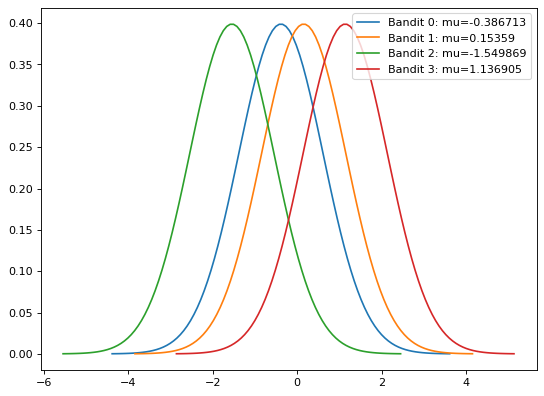

In [340]:
plt.figure(figsize=(8, 6), dpi=80)
for i in range(4):
    mu = round(env.means[0, i], 6)
    sigma = env.stddevs[0, i]
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=f'Bandit {i}: mu={mu}')
plt.legend()
plt.show()

# Evaluating our actions
In order to learn something from our interaction with the environment, we need to know how exactly we determine the value of our actions, as well as how to keep that value up to date. A simple strategy our agents can take is to calculate the expected return for each action. This can be done through experience by taking the average of previous rewards given by a determined action.

For example, we can use the next list of rewards to calculate the expected return of the chosen action: 

$$R_{1...5} = [4.5, 5.04, 5.32, 4.8, 5.11]$$

$$Q_n := {{R_1 + R_2 + ... + R_n} \over n} = {{4.5 + 5.04 + 5.32 + 4.8 + 5.11} \over 5} = 4.954$$

Having to iterate over all of the previous rewards each time we want to calculate the value of an action is inefficient. We can instead use an incremental average update formula, which only requires us to know the previous average $Q_{n - 1}$ and the number $n$:

$$Q_n := Q_{n - 1} + {{R_n - Q_{n - 1}} \over n}$$

$$Q_5 := Q_4 + {{R_5 - Q_4} \over 5} = 4.915 + {{5.11 - 4.915} \over 5} = 4.954$$

# The Greedy Agent
This strategy is focused on always choosing the best known action at the time. Every time the agent takes an action, it looks at the estimated values for each action, and chooses the one that has a greater score. If more than two values look best, then the agent selects arbitrarily among those best-valued actions. This is called breaking ties arbitrarily

Taking the action with the greatest value is equivalent to using the argmax function. Although, we need to implement some changes so that the funciton breaks the ties the way we intend it to do:

In [341]:
def argmax(q_values: np.ndarray) -> np.ndarray:
    """
    Takes in a matrix of n*k q_values and returns the index of the item with the highest value for each row. 
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of the highest value in q_values for each row.
    """
    # Generate a mask of the max values for each row
    mask = q_values == q_values.max(axis=1)[:, None]
    # Generate noise to be added to the ties
    r_noise = (1e-6) * np.random.random(q_values.shape)
    # Get the argmax of the noisy masked values
    return np.argmax(r_noise * mask, axis=1)

## Example

In [396]:
q_values = np.array(
    [
     [1, 2, 10, 10, 5, 6, 10, 3, 10], 
     [10, 2, 10, 7, 10, 10, 1, 3, 4],
     [1, 2, 7, 10, 9, 1, 3, 4, 9]
    ]
)
print(argmax(q_values))

[8 5 3]


In [351]:
class GreedyAgent:
    def __init__(self, num_experiments: int, num_bandits: int, reward_estimates: np.ndarray) -> None:
        """
        The greedy agent contains a matrix for the reward estimates, as well as for the number of times each action has been taken. 
        This is necessary for using the incremental average update rule to update the reward estimates after each interaction with the environment
        """
        assert len(reward_estimates.shape) == 2

        self.num_experiments = num_experiments
        self.num_bandits = num_bandits
        self.reward_estimates = reward_estimates
        self.action_count = np.zeros((num_experiments, num_bandits))
        
    def get_action(self) -> np.ndarray:
        # Our agent is greedy, so there's no need for exploration. Just use our argmax function
        action = argmax(self.reward_estimates)
        # Add a 1 to each action selected in the action count (for each experiment)
        self.action_count[np.arange(self.num_experiments), action] += 1
        return action
    
    def update_estimates(self, reward: np.ndarray, action: np.ndarray) -> None:
        # reward is a matrix with the obtained rewards from our previuos action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.reward_estimates[np.arange(self.num_experiments), action]
        # Update the reward difference incementally
        self.reward_estimates[np.arange(self.num_experiments), action] += (1/n) * error



## Testing the agent
We will see how the agent behaves in the environment. We will see how the agent estimates the values for each action, and we will see the real values provided by the environment. The agent does not have access to the latter.

In [ ]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 100

env = ArmedBanditsGaussian(num_experiments, num_bandits)

# Initialize the agent
agent = GreedyAgent(num_experiments, num_bandits, np.zeros((num_experiments,num_bandits)))

# Code for plotting the interaction
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_ylim(-4, 4)
ax.set_xlim(-0.5, num_bandits-.5)
ax.set_xlabel('Actions', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
ax.axhline(0, color='black', lw=1)

x_pos = np.arange(num_bandits)
estimates = np.zeros(num_bandits)

# Implement a step, which involves the agent acting upon the environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    reward = env.step(action)
    agent.update_estimates(reward, action)
    # Plot the estimated values from the agent compared to the real values
    bar = plt.bar(x_pos, agent.reward_estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
    return bar

ax.plot(x_pos, means, marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
plt.bar(x_pos, agent.reward_estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
#anim.save('./greedy-agent.gif', writer='imagemagick', fps=60)

<img src="images/greedy_animation.gif" width="900"/>
<img src="images/greedy_animation2.gif" width="900"/>
<img src="images/greedy_animation3.gif" width="900"/>

In [361]:
def run_experiments_greedy(num_experiments: int = 10000, num_steps: int = 1000, num_actions: int = 10) -> (np.ndarray, np.ndarray):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = GreedyAgent(num_experiments, num_actions, np.zeros((num_experiments, num_actions)))
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal action for later use
    optimal = np.argmax(env.means, axis=1)
    
    for t in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        reward = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,t+1] = scores[:,t] + reward
        avg_score = np.mean(scores[:,t+1]/(t+1))
        averages[t] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[t] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:02<00:00, 335.98it/s]


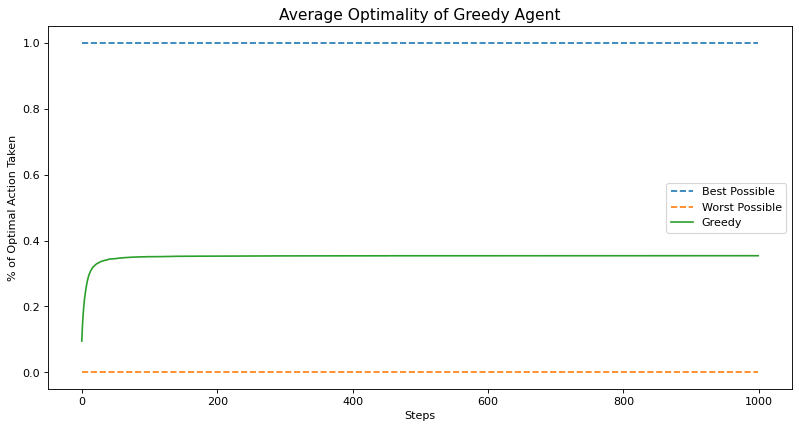

In [354]:
num_experiments=10000
num_steps = 1000
num_actions = 10

greedy_optimality, greedy_scores = run_experiments_greedy(num_experiments, num_steps, num_actions)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

# The ε-Greedy Agent

Another strategy is the Epsilon Greedy Agent, which adds to the previous strategy. An Epsilon-Greedy Agent allows for some exploratory actions, by every once in a while choosing any action randomly, instead of always acting greedily. The probability of taking an exploratory action is defined by the parameter epsilon. An epsilon of 0 is a Greedy Agent. An epsilon of 0.2 means our agent takes a random action 20% of the time. An epsilon of 1 is an agent that behaves randomly.

In [362]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, num_experiments: int, num_actions: int, reward_estimates: np.ndarray, epsilon: float) -> None:
        GreedyAgent.__init__(self, num_experiments, num_actions, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon
    
    def get_action(self) -> np.ndarray:
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

As may be seen, we're inheriting the GreedyAgent implementation, and only changing the get_action function. For taking an action, we're using a masking that defines which experiments will choose an action randomly and which will act greedily. Then, we apply that masking between random and greedy actions to obtain the action vector for all of our experiments.

<img src="images/epsilon_anim.gif" width="900"/>
<img src="images/epsilon_anim2.gif" width="900"/>
<img src="images/epsilon_anim3.gif" width="900"/>

In [204]:
def run_experiment_epsilon(num_experiments: int = 1000, num_steps: int = 1000, num_actions: int = 10, epsilon: float = 0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(num_experiments, num_actions, np.zeros((num_experiments, num_actions)), epsilon)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.means, axis=1)
    
    for t in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        reward = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,t+1] = scores[:,t] + reward
        avg_score = np.mean(scores[:,t+1]/(t+1))
        averages[t] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[t] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:03<00:00, 324.92it/s]


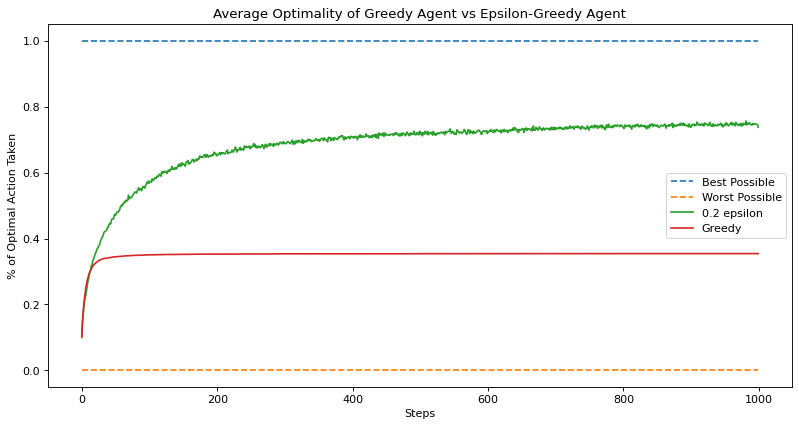

In [280]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilon = 0.2

epsilon_optimality, epsilon_scores = run_experiment_epsilon(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(epsilon_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.2 epsilon", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

# The UCB (Upper Confidence Bound) Agent
Optimism in the face of uncertainty

This method selects the action according to its potential, captured by an upper-confidence interval
## Formula:
- Emperical mean at time t for arm i
    $$\hat{µ}_{i,t} = {{\sum_{s=1}^tr_s} \over n_{i,t}} $$
    $$r_s = \text{ reward obtained during each step}$$
    $$n_{i,t} = \text{ number of times arm i has been pulled at the current time step t}$$
-  Upper confidence bound (UCB) formula
    $$UCB_{i,t} = \hat{µ}_{i,t} + c \sqrt{{\ln{t}} \over n_{i,t}}$$
    $$c = \text{ a number greater than 0 that controls the degree of exploration}$$
- Optimism
    $$|\hat{µ}_{i,t} - µ_{i,t} | < c \sqrt{{\ln{t}} \over n_{i,t}}$$
    $$\text{with probability at least } 1 - {{2} \over t^2} \text{ , this gives a lower bound for UCB: }$$
    $$UCB_{i,t} > µ_{i,t} \text{   with high probability}$$
- Optimistic algorithm
    - At each time step t, play with the best optimistic estimates
    $$i_t = \argmax_{i} UCB_{i,t}$$

In [ ]:
def sqrt0(x):
    return math.sqrt(x)
sqrt = np.vectorize(sqrt0)

In [389]:
class UCBAgent:
    def __init__(self, num_experiments: int, num_bandits: int, emperical_means: np.ndarray, c: int) -> None:
        """
        Our agent takes as input the initial mean estimates
        We will incrementally update the UCB values after each interaction with the environment
        We also take in parameter c which determines the degree of exploration
        """
        assert len(emperical_means.shape) == 2  

        self.num_experiments = num_experiments
        self.num_bandits = num_bandits
        self.emperical_means = emperical_means
        # Initially declare UCB values to be inf (every arm has infinite potential)
        self.ucb_values = np.ones((num_experiments, num_bandits)) * (1e400)
        self.c = c
        self.action_count = np.zeros((num_experiments, num_bandits))
            
        
    def get_action(self) -> None:
        action_selected = argmax(self.ucb_values)
        
        self.action_count[np.arange(self.num_experiments), action_selected] += 1
        return action_selected


    def update_estimates(self, reward: np.ndarray, action: np.ndarray, t: int) -> None:
        n = self.action_count[np.arange(self.num_experiments), action]
        
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.emperical_means[np.arange(self.num_experiments), action]
        
        # Update the emperical mean of this action incementally
        self.emperical_means[np.arange(self.num_experiments), action] += (1/n) * error

        # Update all arms' UCB values with this new t value
        ln_t = math.log(t) if t > 0 else 0
        mask = self.action_count != 0 # to avoid dividing by 0
        self.ucb_values[mask] = self.emperical_means[mask] + self.c * sqrt(ln_t / self.action_count[mask])


In [364]:
def run_experiment_ucb(num_experiments: int = 1000, num_steps: int = 1000, num_actions: int = 10, c: int = 4):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)

    # Initialize the agent
    agent = UCBAgent(num_experiments, num_actions, np.zeros((num_experiments, num_actions)), c)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.means, axis=1)
    
    for t in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        reward= env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action, t + 1)

        # Store the average cumulative score and optimality of the current step
        scores[:,t+1] = scores[:,t] + reward
        avg_score = np.mean(scores[:,t+1]/(t+1))
        averages[t] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[t] = current_optimality
    
    return optimality, averages

100%|██████████| 1000/1000 [00:21<00:00, 47.26it/s]


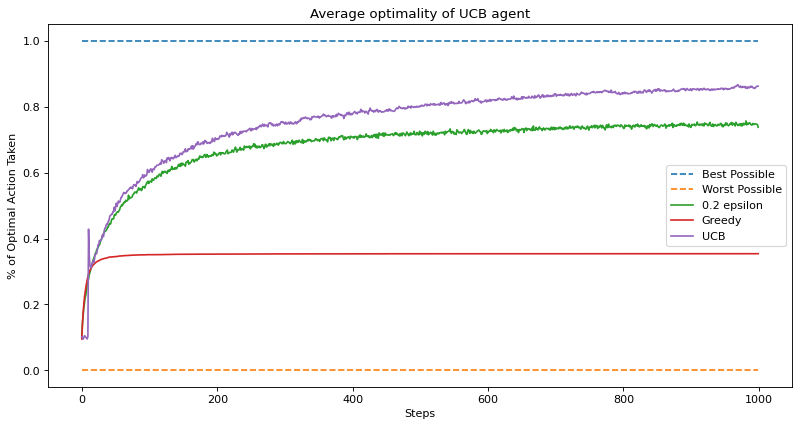

In [390]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
c = 2

ucb_optimality, ucb_scores = run_experiment_ucb(num_experiments, num_steps, num_actions, c)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(epsilon_optimality)
plt.plot(greedy_optimality)
plt.plot(ucb_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.2 epsilon", "Greedy", "UCB"])
plt.title("Average optimality of UCB agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

# The Thompson Sampling Agent

- Natural and efficient heuristic
- Maintain belief (Bayesian posteriors) about parameters (e.g. mean reward) for each arm
- Take sample from every arm's posterior probability distribution, pull arm with largest value
    - This is *not* the same as choosing the arm that is most likely to be best
- Observe feedback, update belief of pulled arm i in Bayesian manner.
    - With less trials, there is more uncertainty in estimates. This spread/variance captures uncertainty: enables **exploration**
    - With more trials, posteriors concentrate on the true parameters. Mode captures MLE: enables **exploitation**

<img src="images/thompson_updating.gif" width="500"/>

## Algorithm

### Bernoulli rewards, Beta Priors

$\text{Beta}(\alpha, \beta) \text{ prior} => \text{ Posterior}$

$$\text{Beta}(\alpha + 1, \beta) \text{ if you observe 1}$$
$$\text{Beta}(\alpha, \beta + 1) \text{ if you observe 0}$$

Start with $\text{Beta}(1,1)$ for every arm

In round t,
- For every arm i, sample $\theta_{i,t}$ independently from posterior $\text{Beta}$($S_{i,t} + 1$,$F_{i,t} + 1$), where $S_{i,t}$ is the number of successes (1) and $F_{i,t}$ is the number of failures (0)
- Play arm $i_t = \max_{i}\theta_{i,t}$
- Observe reward and update the Beta posterior for arm $i_t$

<img src="images/betas.png" width="600"/> 

In [371]:
class ArmedBanditsEnvBernoulli():
    def __init__(self, num_experiments: int, num_bandits: int, p: np.ndarray) -> None:
        assert len(alphas.shape) == 2
        assert len(betas.shape) == 2

        self.num_experiments = num_experiments
        self.num_bandits = num_bandits
        self.p = p
        
    def step(self, action: np.ndarray) -> np.ndarray:
        """
        Sample from the specified bandit using it's reward distribution 
        Action here is an array specifying which arm to pull for each experiment
        """
        assert (action < self.num_bandits).all()
        
        sampled_p = self.p[np.arange(self.num_experiments), action]
        
        reward = np.random.binomial(n=1, p=sampled_p)
        
        return reward
    
    
class ArmedBanditsBinomial(ArmedBanditsEnvBernoulli):
    def __init__(self, num_experiments: int = 1, num_bandits: int = 3) -> None:        
        ArmedBanditsEnvBernoulli.__init__(self, num_experiments, num_bandits, np.random.random((num_experiments, num_bandits)))

In [372]:
class ThompsonAgent:
    def __init__(self, num_experiments: int, num_bandits: int, alphas: np.ndarray, betas: np.ndarray) -> None:
        """
        Our agent takes as input the initial alpha and beta estimates for each arm
        We will incrementally update the alpha and beta values after each interaction with the environment
        """
        assert len(alphas.shape) == 2  
        assert len(betas.shape) == 2 

        self.num_experiments = num_experiments
        self.num_bandits = num_bandits
        self.alphas = alphas
        self.betas = betas
        self.action_count = np.zeros((num_experiments, num_bandits))
            
        
    def get_action(self):
        # Take draws from every arm's beta distribution. The action we select is the one with the maximum sampled value
        thetas = np.random.beta(a=self.alphas, b=self.betas)

        action_selected = argmax(thetas)
        
        self.action_count[np.arange(self.num_experiments), action_selected] += 1
        return action_selected

    
    def update_estimates(self, reward: np.ndarray, action: np.ndarray) -> None:
        # Beta(a + 1, b) if you observe 1
        # Beta(a, b + 1) if you observe 0
        self.alphas[np.arange(self.num_experiments), action] += reward 
        self.betas[np.arange(self.num_experiments), action] += (1 - reward)

In [310]:
def run_experiment_thompson(num_experiments: int = 1000, num_steps: int = 1000, num_actions: int = 10) -> (np.ndarray, np.ndarray):
    # Initialize the environment
    env = ArmedBanditsBinomial(num_experiments, num_actions)

    # Initialize the agent
    alphas = np.ones((num_experiments, num_actions))
    betas = np.ones((num_experiments, num_actions))
    agent = ThompsonAgent(num_experiments, num_actions, alphas, betas)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    # Store the optimal actions for later use
    optimal = np.argmax(env.p, axis=1)
    
    for t in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        reward = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,t+1] = scores[:,t] + reward
        avg_score = np.mean(scores[:,t+1]/(t+1))
        averages[t] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[t] = current_optimality
    
    return optimality, averages

100%|██████████| 1000/1000 [00:11<00:00, 85.40it/s]


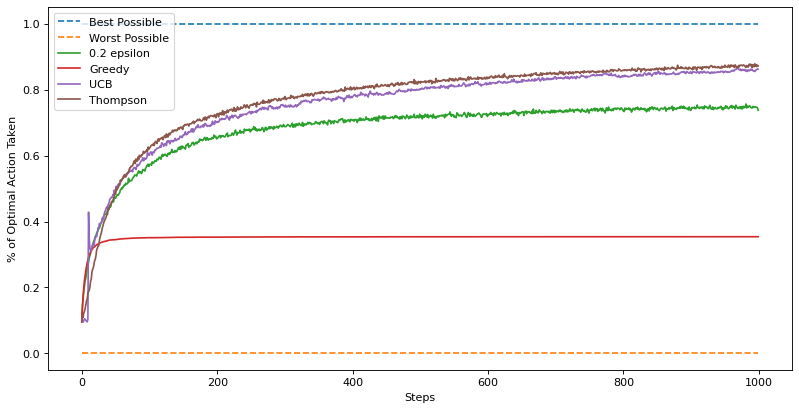

In [391]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

thompson_optimality, thompson_scores = run_experiment_thompson(num_experiments, num_steps, num_actions)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(epsilon_optimality)
plt.plot(greedy_optimality)
plt.plot(ucb_optimality)
plt.plot(thompson_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.2 epsilon", "Greedy", "UCB", "Thompson"])
plt.title("")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

# Useful Generalizations
Take the same basic techniques and apply them to an enormous set of problems which don't meet these assumptions

## Contextual Bandits
- Agent also consideres a d-dimensional feature (context) vector they can use together with the rewards of the arms played in the past to make the choice of the arm to play. 
- Over time, the learner's aim is to collect enough information about how the context vectors and rewards relate to each other, so that it can predict the next best arm to play by looking at the feature vectors

<img src="images/contextual.png" width="600"/> 

## Constrained Contextual Bandit 
- In practice, usually a cost associated with the resource consumed by each action. 
- Total cost is limited by a budget in many applications such as crowdsourcing and clinical trials. 
- Constrained contextual bandit (CCB) is such a model that considers both the time and budget constraints in a multi-armed bandit setting.

## Reinforcement Learning
<img src="images/full_rl.png" width="600"/> 

# References

1) [Hands on MAB](https://towardsdatascience.com/understanding-reinforcement-learning-hands-on-part-2-multi-armed-bandits-526592072bdc)
2) [Recent Advances in Multiarmed Bandits for Sequential Decision Making](https://pubsonline.informs.org/doi/10.1287/educ.2019.0204)
    - [Live presentation](https://www.youtube.com/watch?v=7F0jPUyb7m4)
3) [UCB Theory](https://ieor8100.github.io/mab/Lecture%203.pdf)
4) [Multi-Armed Bandit Analysis of Upper Confidence Bound Algorithm](https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-upper-confidence-bound-algorithm-4b84be516047)
5) [Algorithms with Logarithmic or Sublinear Regret for Constrained Contextual Bandits](https://arxiv.org/abs/1504.06937#:~:text=We%20study%20contextual%20bandits%20with,coupling%20among%20contexts%20over%20time.)
